In [3]:
from operator import truediv

import torch
import numpy as np
import warnings
import matplotlib.pyplot as plt

import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics import Accuracy
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from collections import Counter
from tqdm.autonotebook import tqdm





In [30]:
# https://stackoverflow.com/questions/39719308/keras-model-creates-linear-classification-for-make-moons-data
def plot_decision_boundary(model: nn.Module) -> None:
    # установим минимальные и максимальные значения и добавим паддинг (отступы)
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.1
    # сгенерируем сетку точек, с расстоянием h между ними
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # предскажем
    model.eval() # переводим модель в режим инференса
    with torch.no_grad(): # градиент не считаем
        data = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float32)
        probs = torch.sigmoid(model(data).reshape(xx.shape))
        probs = probs.numpy().reshape(xx.shape)

    # отрисуем точки
    plt.figure(figsize=(15, 6))
    plt.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
    plt.scatter(X[100:, 0], X[100:, 1],
                c=y[100:],
                cmap="RdBu",
                s=50,
                linewidth=1,
                alpha=.42,
                ec="black")
    plt.title("Decision Boundary")
    plt.axis("off")
    plt.show()


In [4]:
X, y = make_moons(n_samples = 5000, random_state=45, noise=.15)
Counter(y)

Counter({1: 2500, 0: 2500})

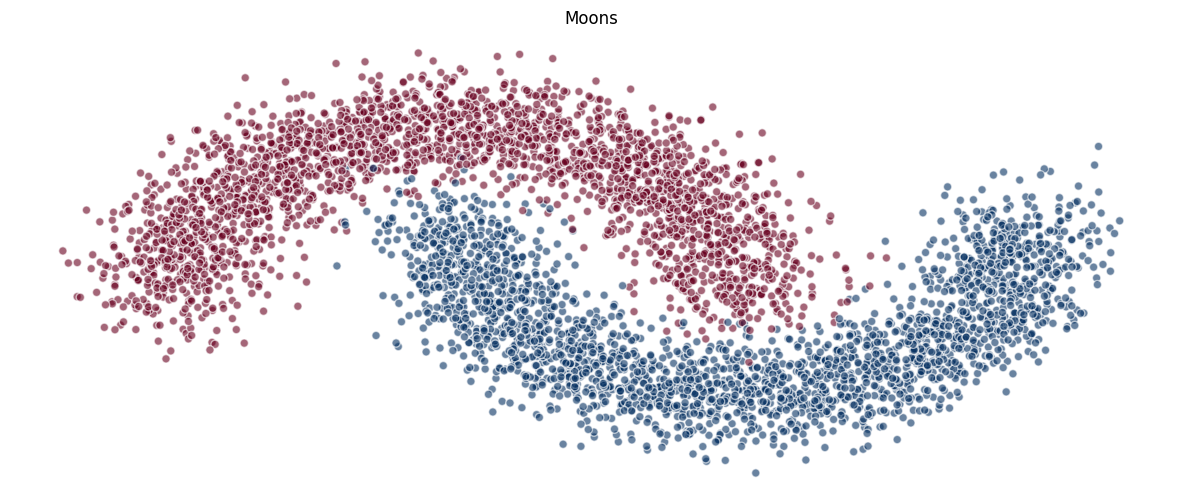

In [5]:
plt.figure(figsize=(15, 6))
plt.title('Moons')
plt.scatter(X[:, 0], X[:, 1],
            c=y,
            cmap='RdBu',
            alpha=.60,
            ec='white')
plt.axis('off')
plt.show()
           

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [8]:
train_X = torch.from_numpy(X_train).to(torch.float32)
train_y = torch.from_numpy(y_train).type_as(train_X)
val_X = torch.from_numpy(X_val).to(torch.float32)
val_y = torch.from_numpy(y_val).type_as(val_X)

In [9]:
BATCH = 64
train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)

train_loader = DataLoader(train_dataset, batch_size=BATCH)
val_loader = DataLoader(val_dataset, batch_size=BATCH)

In [10]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

Линейная модель: \
$ y = xW + b$

In [22]:
class MyLinearRegression(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.W = nn.Parameter(torch.randn((in_features, out_features),
                                      requires_grad=True)
                          )
        self.b = nn.Parameter(torch.ones(out_features),
                          requires_grad=True)
        
    def forward(self, x):
        x = x @ self.W
        x += self.b
        return x
    

In [27]:
# задаем модель
model = MyLinearRegression(2, 1)
# задаем функцию  потерь
loss_function = nn.BCEWithLogitsLoss()
#задать оптимизатор
optimizer = torch.optim.SGD(model.parameters(), lr=.042)

# поместить модель и метрику на GPU
model = model.to(DEVICE)
accuracy = Accuracy(task='binary').to(DEVICE)

# лосс на каждой итерации
losses_train = []
# общий лосс
total_loss = []
# Accuracy на валидации
acc_val = []
# задать общее число эпох
MAX_EPOCHS = 100

# для каждой эпохи
for epoch in tqdm(range(MAX_EPOCHS)):
    # для каждой части датасета
    for iteration, (X_batch, y_batch) in enumerate(train_loader):
        # ЭТАП ОБУЧЕНИЯ
        model.train()
        # обнуляем градиенты оптизатора
        optimizer.zero_grad()
        # пропускаем данные через модель
        outputs = model(X_batch.to(DEVICE))
        # выравниваем выходы в одномерный тензор
        outputs  = outputs.view(-1)
        # считаем лосс
        loss = loss_function(outputs, y_batch.to(DEVICE))
        # делаем шаг в обратном напралвении ошибки
        loss.backward()
        # собираем лоссы
        losses_train.append(loss.detach().cpu().numpy().item())
        # делаем шаг оптимизатора
        optimizer.step()
    # собираем средний лосс
    total_loss.append(np.mean(losses_train))
    # ШАГ ВАЛИДАЦИИ
    for iteration, (X_batch, y_batch) in enumerate(val_loader):
        # режим инференса (валидации, тестирования)
        model.eval()
        # больше не юзаем оптимизатор
        with torch.no_grad():
            outputs = model(X_batch.to(DEVICE))
            outputs  = outputs.view(-1)
            loss = loss_function(outputs, y_batch.to(DEVICE))
            # считаем вероятности
            proba = torch.sigmoid(outputs)
            # считаем метрику
            batch_acc = accuracy(proba, y_batch.to(torch.int32).to(DEVICE))
            acc_val.append(batch_acc.detach().cpu().numpy().item())
            
        
    



100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


In [28]:
acc = np.mean(acc_val)
print(f'accuracy линейной модели {acc: .2%}')

accuracy линейной модели  86.15%


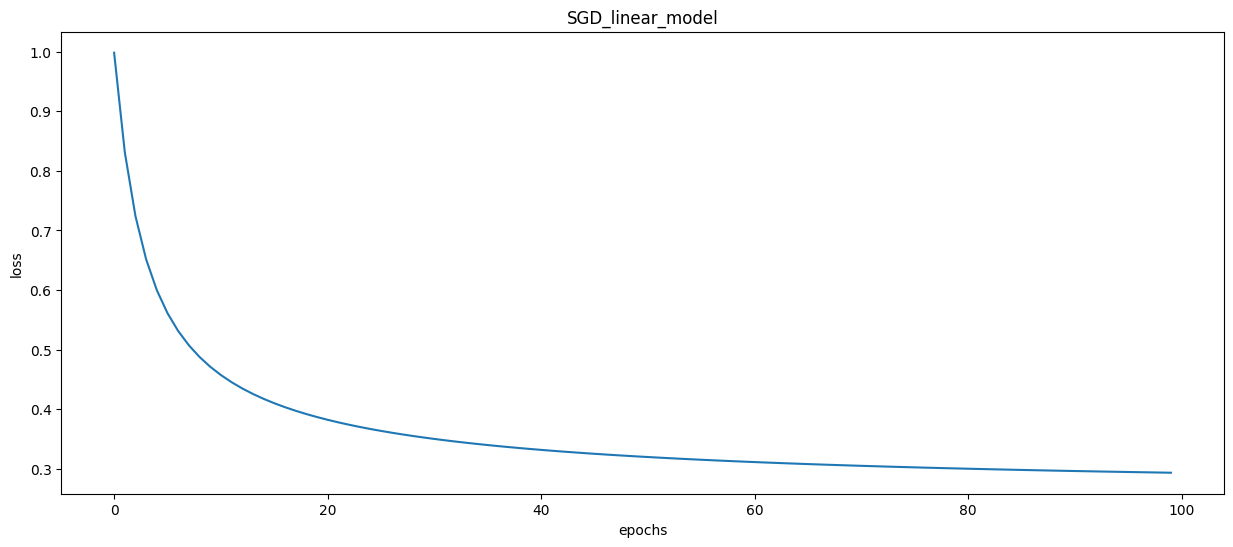

In [29]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(total_loss)),
         total_loss,
         linestyle='-'
         )
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('SGD_linear_model')
plt.show()

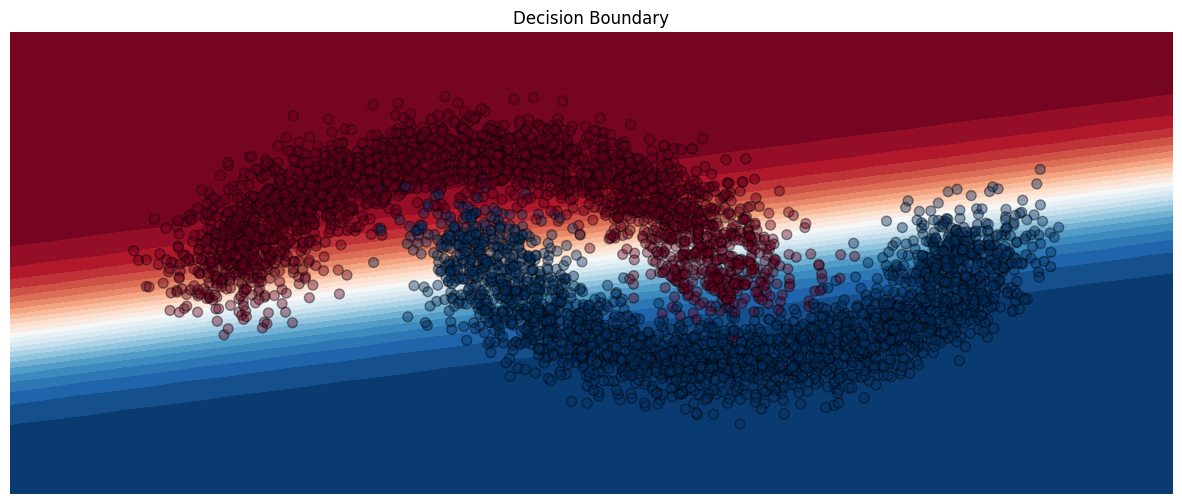

In [31]:
plot_decision_boundary(model.to('cpu'))

In [32]:
with torch.no_grad():
    torch.cuda.empty_cache()

сеть

In [33]:
class NN(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.lin_linear_1 = self.make_layer(in_features, in_features * 4)
        self.lin_linear_2 = self.make_layer(in_features * 4, in_features * 2)
        self.lin_linear_3 = self.make_layer(in_features * 2,  out_features)
        self.relu = F.relu

    def make_layer(self, in_f, out_f):
        return nn.Linear(in_f, out_f)
        
    def forward(self, x):
        x = self.lin_linear_1(x)
        x = self.relu(x)
        x = self.lin_linear_2(x)
        x = self.relu(x)
        x = self.lin_linear_3(x)
        return x
    

обучение

In [34]:
# задаем модель
model = NN(2, 1)
# задаем функцию  потерь
loss_function = nn.BCEWithLogitsLoss()
#задать оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=.042)

In [35]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.3436,  0.2819],
         [-0.2023,  0.1904],
         [-0.2279,  0.0862],
         [ 0.6552,  0.0722],
         [-0.1784, -0.1269],
         [-0.5024, -0.4730],
         [-0.1517, -0.3162],
         [-0.2161,  0.4884]], requires_grad=True),
 Parameter containing:
 tensor([ 0.3873,  0.5403,  0.2137, -0.5443, -0.5764, -0.4712, -0.0838, -0.5125],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.2538,  0.0803,  0.1233,  0.2620, -0.0442,  0.3217,  0.1545, -0.1246],
         [ 0.0359,  0.0614, -0.1459,  0.0899, -0.1755,  0.2566,  0.2489,  0.3027],
         [ 0.2472, -0.0098,  0.0863, -0.0039,  0.3139, -0.2181,  0.0691, -0.2303],
         [ 0.2336,  0.2772,  0.2116, -0.0546, -0.0092,  0.2283, -0.0371, -0.1805]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.2432,  0.1770, -0.1647,  0.0378], requires_grad=True),
 Parameter containing:
 tensor([[ 0.3905, -0.4341, -0.0746,  0.4024]], requires_grad=True),
 Parameter containing:

In [36]:
# поместить модель и метрику на GPU
model = model.to(DEVICE)
accuracy = Accuracy(task='binary').to(DEVICE)

# лосс на каждой итерации
losses_train = []
# общий лосс
total_loss = []
# Accuracy на валидации
acc_val = []
# задать общее число эпох
MAX_EPOCHS = 100

# для каждой эпохи
for epoch in tqdm(range(MAX_EPOCHS)):
    # для каждой части датасета
    for iteration, (X_batch, y_batch) in enumerate(train_loader):
        # ЭТАП ОБУЧЕНИЯ
        model.train()
        # обнуляем градиенты оптизатора
        optimizer.zero_grad()
        # пропускаем данные через модель
        outputs = model(X_batch.to(DEVICE))
        # выравниваем выходы в одномерный тензор
        outputs  = outputs.view(-1)
        # считаем лосс
        loss = loss_function(outputs, y_batch.to(DEVICE))
        # делаем шаг в обратном напралвении ошибки
        loss.backward()
        # собираем лоссы
        losses_train.append(loss.detach().cpu().numpy().item())
        # делаем шаг оптимизатора
        optimizer.step()
    # собираем средний лосс
    total_loss.append(np.mean(losses_train))
    # ШАГ ВАЛИДАЦИИ
    for iteration, (X_batch, y_batch) in enumerate(val_loader):
        # режим инференса (валидации, тестирования)
        model.eval()
        # больше не юзаем оптимизатор
        with torch.no_grad():
            outputs = model(X_batch.to(DEVICE))
            outputs  = outputs.view(-1)
            loss = loss_function(outputs, y_batch.to(DEVICE))
            # считаем вероятности
            proba = torch.sigmoid(outputs)
            # считаем метрику
            batch_acc = accuracy(proba, y_batch.to(torch.int32).to(DEVICE))
            acc_val.append(batch_acc.detach().cpu().numpy().item())
            
        
    



100%|██████████| 100/100 [00:26<00:00,  3.74it/s]


In [37]:
acc = np.mean(acc_val)
print(f'accuracy сети {acc: .2%}')

accuracy сети  98.87%


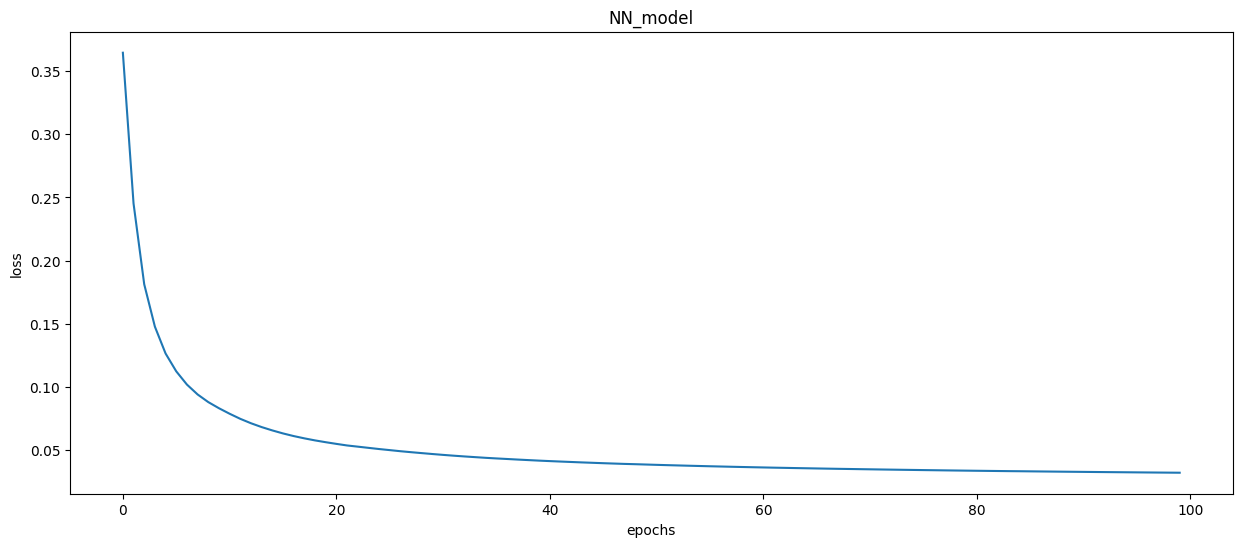

In [38]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(total_loss)),
         total_loss,
         linestyle='-'
         )
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('NN_model')
plt.show()

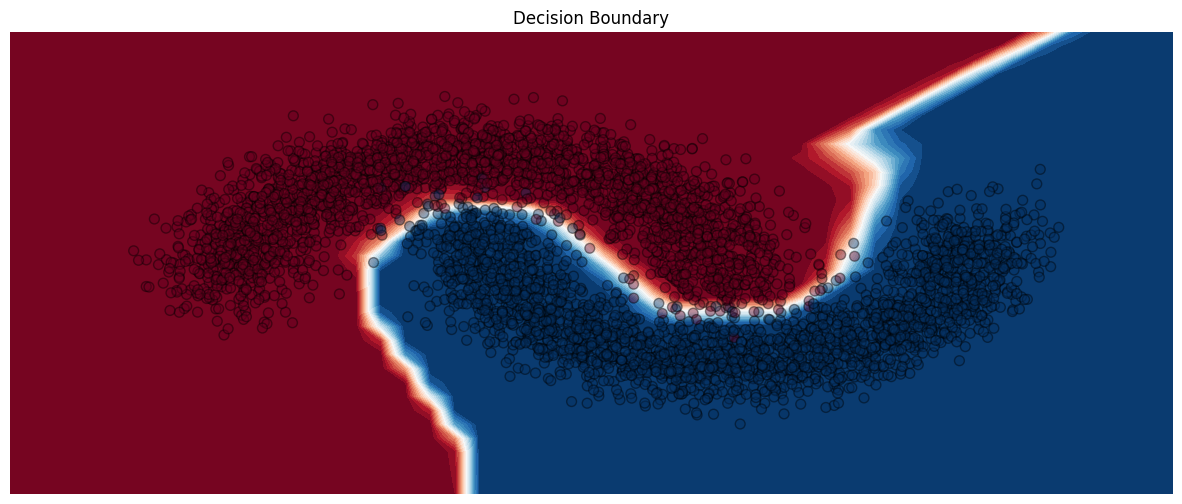

In [39]:
plot_decision_boundary(model.to('cpu'))

In [40]:
with torch.no_grad():
    torch.cuda.empty_cache()